In [2]:
from PyPDF2 import PdfReader
#pdf_files = ['inputdata/2024-large-group-health-plans-brochure.pdf', 'inputdata/2024-fixed-funding-benefit-designs.pdf', 'inputdata/baags-seh-2024.pdf']
pdf_files = ['inputdata/2024-large-group-health-plans-brochure.pdf']


def format_docs(pdf_files):
    text = ""
    for pdf_file in pdf_files:
        reader = PdfReader(pdf_file)
        for i in range(0, len(reader.pages)):
            page = reader.pages[i]
            text += page.extract_text() + " "
    return text

text= format_docs(pdf_files) 

In [3]:
def display_word_cloud(top_100_words):
  wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(top_100_words))

  plt.figure(figsize=(10, 5))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')
  plt.show()

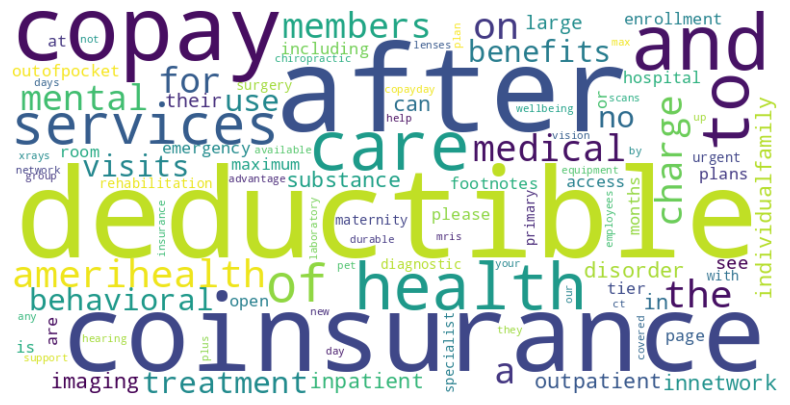

In [4]:
import re
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text = re.sub(r'[^a-zA-Z\s]', '', text)
text = text.lower()
words = text.split()
word_counts = Counter(words)
top_100_words = word_counts.most_common(100)

display_word_cloud(top_100_words)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\avssm\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


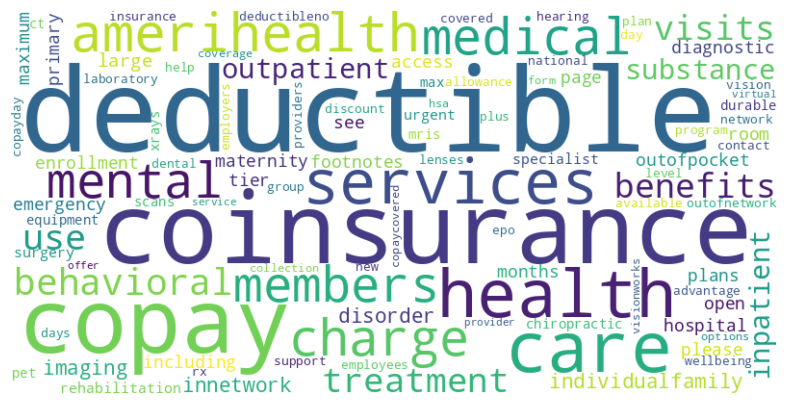

In [5]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

# Filter out stop words from your list of words
filtered_words = [word for word in words if word not in stop_words]
word_counts_filtered = Counter(filtered_words)

# If you still want to limit it to the top 100 words
top_100_words_filtered = word_counts_filtered.most_common(100)

display_word_cloud(top_100_words_filtered)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\avssm\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\avssm\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\avssm\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


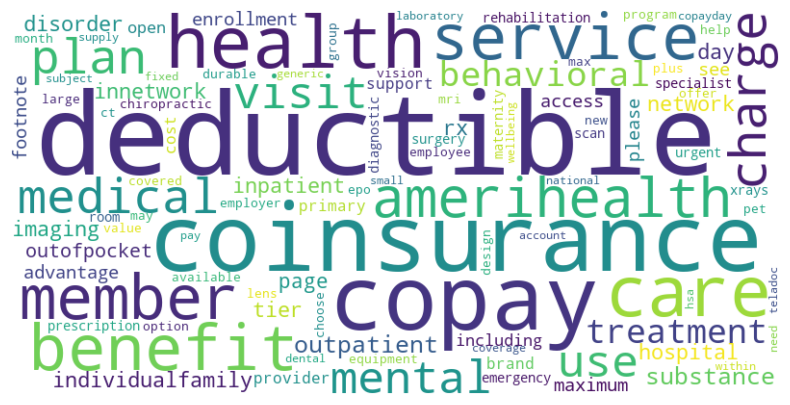

In [25]:
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter

# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()
tokens = word_tokenize(text)  # Tokenize the text
stop_words = set(stopwords.words('english'))

# Lemmatize tokens and remove stop words
lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words and token.isalpha()]

# Recount words
word_counts = Counter(lemmatized_tokens)

# Extract the top 100 words
top_100_words_lemmatized = word_counts.most_common(100)
display_word_cloud(top_100_words_lemmatized)

In [6]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.schema.document import Document

documents = [Document(page_content=text, metadata={"source": "local"})]
text_splitter = RecursiveCharacterTextSplitter(chunk_size=200, chunk_overlap=40)
all_splits = text_splitter.split_documents(documents)

In [7]:
import os
import json 
from dotenv import load_dotenv
load_dotenv()
 # accessing and printing value
#print(os.getenv("HF_TOKEN"))

True

In [34]:
from langchain.embeddings import HuggingFaceEmbeddings
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2", model_kwargs={"device": "cpu"})

OSError: [WinError 126] The specified module could not be found. Error loading "C:\Users\avssm\AppData\Roaming\Python\Python311\site-packages\torch\lib\shm.dll" or one of its dependencies.

In [8]:
from langchain_community.embeddings import OllamaEmbeddings
ollama_emb = OllamaEmbeddings(
    model="mxbai-embed-large:latest",
)

In [9]:
from langchain.vectorstores import Chroma
vectordb_paper = Chroma.from_documents(documents=all_splits, embedding=ollama_emb, persist_directory="chroma_db_AMHpdf")
retriever_paper = vectordb_paper.as_retriever()

In [10]:
from langchain_community.llms import Ollama
llm = Ollama(model="llama3:latest")

#from langchain_groq import ChatGroq
#llm = ChatGroq(model_name="llama3-70b-8192")

In [11]:
from langchain.chains import RetrievalQA
qa_paper = RetrievalQA.from_chain_type(
    llm,
    chain_type="stuff",
    retriever=retriever_paper,
    verbose=True
)

C:\Users\avssm\AppData\Roaming\Python\Python311\site-packages\langchain_core\_api\deprecation.py:119: LangChainDeprecationWarning: The method `Chain.__call__` was deprecated in langchain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(




> Entering new RetrievalQA chain...

> Finished chain.


{'result': "Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer.\n\ninnetwork benefitna na\npreventive services\nexamsevaluations\nno charge not subject to deductible no charge not subject to deductible\ncleaningsxrays\nfluoride treatments sealants\n\nmedical benefits innetwork outofnetwork\ndeductible     \nindividualfamily  \nmaximum outofpocket    \nindividualfamily  \nprimary care visits  copay  coinsurance   \nafter deductible\n\nmedical benefits innetwork outofnetwork\ndeductive     \nindividualfamily  \nmaximum outofpocket    \nindividualfamily  \nprimary care visits  copay  coinsurance   \nafter deductible\n\nmedical benefits innetwork outofnetwork\ndeductible     \nindividualfamily  \nmaximum outofpocket    \nindividualfamily  \nprimary care visits  copay  coinsurance   \nafter deductible\n\nQuestion: What are the preventive services that are available at no charge and

In [12]:
def rag_manager(qa, query):
    print("\nResult: ", qa.run(query))

In [13]:
rag_manager(qa_paper, "What are the bronze plans?")

C:\Users\avssm\AppData\Local\Temp\ipykernel_35104\199207027.py:2: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use invoke instead.
  print("\nResult: ", qa.run(query))




> Entering new RetrievalQA chain...

> Finished chain.

Result:  Based on the provided context, I don't have enough information to answer the question about the bronze plans. The text appears to be discussing various vision care options and benefits, but it doesn't mention anything specific about "bronze plans." If you could provide more context or clarify what you mean by "bronze plans," I may be able to help further.


In [14]:
rag_manager(qa_paper, "What are best plans for large employers ?")



> Entering new RetrievalQA chain...

> Finished chain.

Result:  Based on the provided context, it appears that AmeriHealth Advantage Health Plans with "cost-saving tiered benefits" and a focus on "affordability" are likely the best plans for large employers. These plans also offer "streamlined benefits administration" and provide a tool called "benefits at a glance" to help manage employee health plans.


In [15]:
from langchain import hub
prompt = hub.pull("rlm/rag-prompt")

c:\Users\avssm\miniconda3\envs\LLM_training\Lib\site-packages\langsmith\client.py:322: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(
c:\Users\avssm\miniconda3\envs\LLM_training\Lib\site-packages\langsmith\client.py:5301: LangChainBetaWarning: The function `loads` is in beta. It is actively being worked on, so the API may change.
  prompt = loads(json.dumps(prompt_object.manifest))


In [16]:
prompt

ChatPromptTemplate(input_variables=['context', 'question'], metadata={'lc_hub_owner': 'rlm', 'lc_hub_repo': 'rag-prompt', 'lc_hub_commit_hash': '50442af133e61576e74536c6556cefe1fac147cad032f4377b60c436e6cdcb6e'}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], template="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:"))])

In [24]:

from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
# Building the RAG
rag_pdf = (
    {"context": retriever_paper, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

In [25]:
def respond(input_text):
    return rag_pdf.invoke(input_text)

In [26]:
import gradio as gr

In [27]:


with gr.Blocks() as app:
    gr.Markdown("## Q/A system ##")
    with gr.Row():
        input_text = gr.Textbox(label="Your Input")
        submit_button = gr.Button("Submit")
    output_text = gr.Textbox(label="Response from the BOT")
    submit_button.click(fn=respond, inputs=[input_text], outputs=output_text)

app.launch()

Running on local URL:  http://127.0.0.1:7863

To create a public link, set `share=True` in `launch()`.


IMPORTANT: You are using gradio version 4.29.0, however version 4.44.1 is available, please upgrade.
--------
